In [1]:
import numpy as np
import pandas as pd
from glob import glob
import wfdb
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

In [2]:
def ltafdb_paths(folder: str) -> list[str]:
    # Get all the signal headers
    query = os.path.join(folder, "*.hea")
    paths = glob(query)

    # Get rid of the extension
    paths = [path[:-4] for path in paths]

    return paths


def load_ltafdb_record(record_path: str):
    ann = wfdb.rdann(record_path, "atr")
    # Convert to a convenient dataframe
    adf = pd.DataFrame({"symbol": ann.symbol, "aux": ann.aux_note, "position": ann.sample})

    signals, fields = wfdb.rdsamp(record_path)

    return signals, adf, fields

In [3]:
# That's where I'm downloading the LTAFDB data
folder = "../physionet.org/files/ltafdb/1.0.0/"
paths = ltafdb_paths(folder) 

signals, adf, fields = load_ltafdb_record(paths[0])

# It has 2 channels
print("Signals shape:", signals.shape)

print("Number of annotations:", adf.shape[0])
print("Annotation distribution:")
print(adf.symbol.value_counts())

Signals shape: (9661440, 2)
Number of annotations: 106337
Annotation distribution:
N    105416
V       778
+        89
A        53
"         1
Name: symbol, dtype: int64


In [4]:
fields

{'fs': 128,
 'sig_len': 9661440,
 'n_sig': 2,
 'base_date': datetime.date(2003, 1, 31),
 'base_time': datetime.time(9, 30),
 'units': ['mV', 'mV'],
 'sig_name': ['ECG', 'ECG'],
 'comments': []}

In [5]:
adf

,symbol,aux,position
0,+,(N,83607
1,N,,83628
2,N,,83736
3,N,,83844
4,N,,83953
...,...,...,...
106332,N,,9660519
106333,N,,9660637
106334,N,,9660759
106335,N,,9660879


In [9]:
adf["symbol"].values

array(['+', 'N', 'N', ..., 'N', 'N', 'N'], dtype=object)

In [10]:
signal_df = pd.DataFrame(signals, columns=["channel_1", "channel_2"])

In [11]:
signal_df

,channel_1,channel_2
0,-0.00599,0.017340
1,-0.01198,0.023120
2,0.00599,0.017340
3,0.00000,0.017340
4,-0.01198,0.017340
...,...,...
9661435,-0.13178,-0.190740
9661436,-0.14975,-0.190740
9661437,-0.15574,-0.208080
9661438,-0.15574,-0.156060


In [12]:
fs = 125

In [13]:
dilation = int((0.1 * fs) // 2)

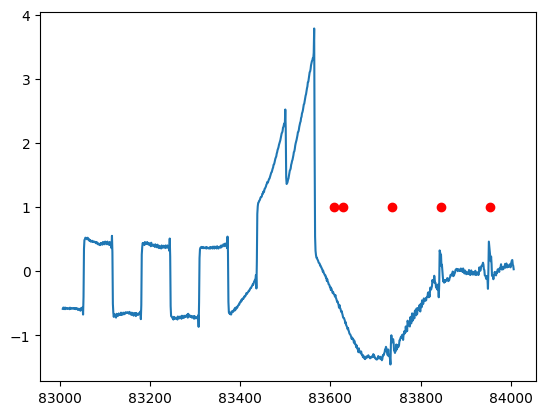

In [14]:
window = slice(83007, 83007+1000)
b = adf[adf["position"].between(83007, 83007+1000)]["position"]

plt.plot(np.arange(83007, 83007+1000), signal_df["channel_1"][window])
plt.scatter(b, np.ones_like(b), c="red")

In [15]:
adf_2 = adf.set_index("position")

In [16]:
tmp = pd.merge(signal_df, adf_2, how="left", right_index=True, left_index=True)

In [17]:
tmp

,channel_1,channel_2,symbol,aux
0,-0.00599,0.017340,NaN,NaN
1,-0.01198,0.023120,NaN,NaN
2,0.00599,0.017340,NaN,NaN
3,0.00000,0.017340,NaN,NaN
4,-0.01198,0.017340,NaN,NaN
...,...,...,...,...
9661435,-0.13178,-0.190740,NaN,NaN
9661436,-0.14975,-0.190740,NaN,NaN
9661437,-0.15574,-0.208080,NaN,NaN
9661438,-0.15574,-0.156060,NaN,NaN


In [18]:
cond = tmp.symbol.isin(["N", "V", "A"])

In [19]:
cond

0          False
1          False
2          False
3          False
4          False
           ...  
9661435    False
9661436    False
9661437    False
9661438    False
9661439    False
Name: symbol, Length: 9661440, dtype: bool

In [20]:
a = np.where(binary_dilation(cond, iterations=dilation), 1, 0)

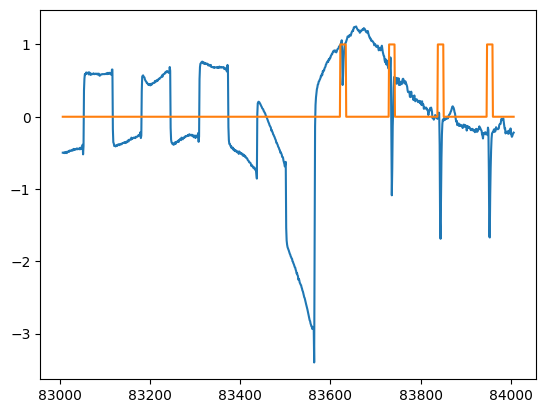

In [18]:
plt.plot(np.arange(83007, 83007+1000), tmp.channel_2[83007:83007+1000])
plt.plot(np.arange(83007, 83007+1000), a[83007:83007+1000])

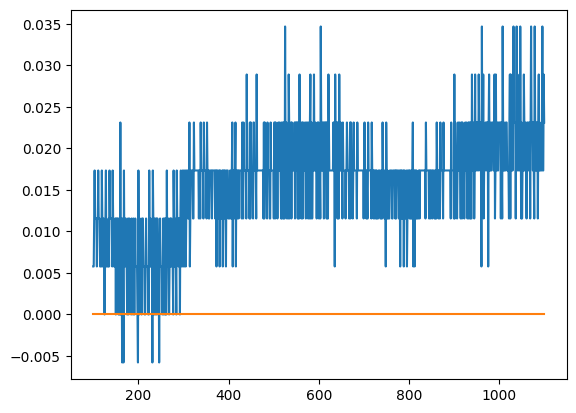

In [19]:
plt.plot(np.arange(100, 100+1000), tmp.channel_2[100:100+1000])
plt.plot(np.arange(100, 100+1000), a[100:100+1000])

In [22]:
tmp["mask"] = a

In [23]:
tmp

,channel_1,channel_2,symbol,aux,mask
0,-0.00599,0.017340,NaN,NaN,0
1,-0.01198,0.023120,NaN,NaN,0
2,0.00599,0.017340,NaN,NaN,0
3,0.00000,0.017340,NaN,NaN,0
4,-0.01198,0.017340,NaN,NaN,0
...,...,...,...,...,...
9661435,-0.13178,-0.190740,NaN,NaN,0
9661436,-0.14975,-0.190740,NaN,NaN,0
9661437,-0.15574,-0.208080,NaN,NaN,0
9661438,-0.15574,-0.156060,NaN,NaN,0


In [24]:
tmp.dtypes

channel_1    float64
channel_2    float64
symbol        object
aux           object
mask           int64
dtype: object

In [22]:
a = []
for subset in tmp.rolling(1000, step=1000, min_periods=1000):
    if len(subset) != 1000:
        continue
    a.append(subset)

In [23]:
len(a)

9661

In [27]:
a

[      channel_1  channel_2 symbol  aux  mask
 1      -0.01198    0.02312    NaN  NaN     0
 2       0.00599    0.01734    NaN  NaN     0
 3       0.00000    0.01734    NaN  NaN     0
 4      -0.01198    0.01734    NaN  NaN     0
 5       0.00000    0.01734    NaN  NaN     0
 ...         ...        ...    ...  ...   ...
 996     0.00000    0.01734    NaN  NaN     0
 997    -0.01198    0.01734    NaN  NaN     0
 998    -0.01198    0.02312    NaN  NaN     0
 999    -0.01198    0.02312    NaN  NaN     0
 1000   -0.01797    0.02312    NaN  NaN     0
 
 [1000 rows x 5 columns],
       channel_1  channel_2 symbol  aux  mask
 1001   -0.01198    0.02312    NaN  NaN     0
 1002   -0.00599    0.02312    NaN  NaN     0
 1003   -0.01198    0.01156    NaN  NaN     0
 1004   -0.01797    0.02312    NaN  NaN     0
 1005   -0.01198    0.01734    NaN  NaN     0
 ...         ...        ...    ...  ...   ...
 1996    0.01797    0.02312    NaN  NaN     0
 1997    0.01198    0.02890    NaN  NaN     0
 1998 

In [31]:
a[1].index[-1]

2000